<a href="https://colab.research.google.com/github/shubhamphal/One-NLP/blob/master/MultiLabel_Classification_of_Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle Toxic Comments Classification
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/

The following code gives a roc_auc score of 0.97271 on public test set and
0.97190 on private test set

In [ ]:
 !pip install -q kaggle

Get Kaggle API token and upload Kaggle.json

In [ ]:
 !mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge


Download GLoVe

In [ ]:
!wget nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove.6B.zip

In [62]:
import os
import sys
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, GlobalMaxPooling1D, Bidirectional, LSTM, GRU, GlobalMaxPool1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
from keras.optimizers import Adam
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
#Extract test, train and labels 
import zipfile
with zipfile.ZipFile('test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())
with zipfile.ZipFile('train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

In [ ]:
EMBEDDING_DIM=100
MAX_VOCAB_SIZE=20000
MAX_SEQUENCE_LENGTH=100

In [ ]:
f=open(os.path.join('.','glove.6B.%sd.txt'%EMBEDDING_DIM))

In [ ]:
stop_words = set(stopwords.words('english')) 

In [ ]:
word2vec={}
for line in f:
    values=line.split()
    word=values[0]
    vector=np.asarray(values[1:],dtype='float32')
    word2vec[word]=vector

In [ ]:
train_data=pd.read_csv('train.csv')

In [ ]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
def preprocessed(comment):
    words = nltk.word_tokenize(comment)
    words=[word.lower() for word in words if word.isalpha()]
    words=[word for word in words if word not in stop_words]
    return ' '.join(words)

In [ ]:
comment1=train_data['comment_text'].iloc[0]
print("Natural",comment1)
print("Preprocessing",preprocessed(comment1))

Natural Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Preprocessing explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired


In [ ]:
train_data['preprocessed_comments']=train_data['comment_text'].apply(preprocessed)

In [ ]:
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [ ]:
sentences=train_data['preprocessed_comments'].values
targets=train_data[possible_labels].values

In [ ]:
print('max sequence length :',max(len(s) for s in sentences))
print('min sequence length :',min(len(s) for s in sentences))
sorted_lens= sorted(len(s) for s in sentences)
print('median sequence length',sorted_lens[len(sorted_lens)//2])

max sequence length : 5000
min sequence length : 0
median sequence length 119


In [ ]:
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences=tokenizer.texts_to_sequences(sentences)
print("max word index:", max(max(seq) for seq in sequences if len(seq) > 0))

max word index: 19999


In [ ]:
word2idx=tokenizer.word_index
print('Found %s unique tokens'%len(word2idx))

Found 157304 unique tokens


In [ ]:
data=pad_sequences(sequences,maxlen=MAX_SEQUENCE_LENGTH)
print(data.shape)

(159571, 100)


In [ ]:
np.random.seed(0)
num_words=min(MAX_VOCAB_SIZE,len(word2idx)+1)
embedding_matrix=np.random.randn(num_words,EMBEDDING_DIM)*0.1
for word, i in word2idx.items():
    if i<MAX_VOCAB_SIZE:
        embedding_vector=word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [ ]:
print(embedding_matrix)

In [53]:
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False)

In [ ]:
#1D Convolutions Approach
#input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
#x=embedding_layer(input_)
#x=Conv1D(128,3,activation='relu')(x)
#x=MaxPooling1D(3)(x)
#x=Conv1D(128,3,activation='relu')(x)
#x=MaxPooling1D(3)(x)
#x=Conv1D(128,3,activation='relu')(x)
#x=GlobalMaxPooling1D()(x)
#x=Dense(128,activation='relu')(x)
#ouput_= Dense(len(possible_labels),activation='sigmoid')(x)

In [59]:
input_=Input(shape=(MAX_SEQUENCE_LENGTH,))
x=embedding_layer(input_)
x=Bidirectional(LSTM(64,return_sequences=True,dropout=0.1))(x)
x=GlobalMaxPooling1D()(x)
ouput_= Dense(len(possible_labels),activation='sigmoid')(x)

In [60]:
model=Model(input_,ouput_)

In [63]:
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.01),metrics=['accuracy'])

In [64]:
r=model.fit(data,targets,epochs=10,validation_split=0.2,batch_size=128)

Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 330s 3ms/step - loss: 0.0622 - accuracy: 0.9787 - val_loss: 0.0531 - val_accuracy: 0.9810
Epoch 2/10
127656/127656 [==============================] - 323s 3ms/step - loss: 0.0514 - accuracy: 0.9815 - val_loss: 0.0519 - val_accuracy: 0.9812
Epoch 3/10
127656/127656 [==============================] - 326s 3ms/step - loss: 0.0494 - accuracy: 0.9820 - val_loss: 0.0508 - val_accuracy: 0.9820
Epoch 4/10
127656/127656 [==============================] - 324s 3ms/step - loss: 0.0479 - accuracy: 0.9825 - val_loss: 0.0507 - val_accuracy: 0.9816
Epoch 5/10
127656/127656 [==============================] - 326s 3ms/step - loss: 0.0471 - accuracy: 0.9827 - val_loss: 0.0510 - val_accuracy: 0.9814
Epoch 6/10
127656/127656 [==============================] - 326s 3ms/step - loss: 0.0464 - accuracy: 0.9829 - val_loss: 0.0506 - val_accuracy: 0.9817
Epoch 7/10
127656/127656 [=======================

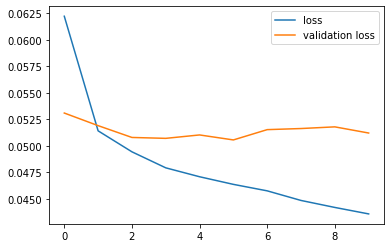

In [65]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='validation loss')
plt.legend()
plt.show()

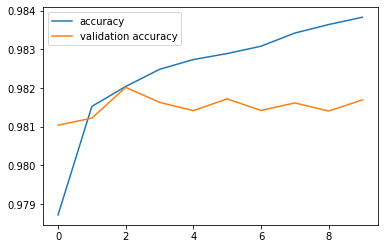

In [66]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='validation accuracy')
plt.legend()
plt.show()

ROC AUC SCORE

In [67]:
predictions=model.predict(data)
aucs=[]
for j in range(6):
    auc=roc_auc_score(targets[:,j],predictions[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9878514100310082


In [68]:
test_data=pd.read_csv('test.csv')

In [69]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [70]:
test_data['preprocessed_comments']=test_data['comment_text'].apply(preprocessed)
test_sentences_comments=test_data['preprocessed_comments'].values

In [71]:
test_sequences=tokenizer.texts_to_sequences(test_sentences_comments)

In [72]:
test_data_seq=pad_sequences(test_sequences,maxlen=MAX_SEQUENCE_LENGTH)

In [73]:
test_predictions=model.predict(test_data_seq)

In [74]:
result_df=pd.DataFrame(data=test_predictions,columns=possible_labels,index=test_data.id)

In [75]:
result_df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
00001cee341fdb12,0.997365,0.747027,0.948352,2.500340e-01,0.955383,0.756898
0000247867823ef7,0.000761,0.000065,0.000145,2.344406e-07,0.000128,0.000017
00013b17ad220c46,0.003128,0.000304,0.003160,9.205747e-05,0.001777,0.000757
00017563c3f7919a,0.001096,0.000004,0.000378,1.358188e-05,0.000219,0.000007
00017695ad8997eb,0.002158,0.000315,0.001962,9.907693e-05,0.001038,0.000136


In [76]:
result_df.to_csv(r'Bidirectional_Lstm64_GloVe_with_preprocessing.csv')